In [1]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from lib.nasdaq import Fundamentals, Tickers, Nasdaq
from lib.equity.fundamentals import peer_percentiles

from lib.calendar import Calendar
cal = Calendar()

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
ticker = 'GOOGL'

In [5]:
Nasdaq().authenticate()

In [6]:
def calculate_fundamentals(df):
    df['total_expense'] = df['revenue'] - df['netinc']
    df['pbt'] = df['revenue'] - df['total_expense'] + df['taxexp'] 
    df['tax_rate'] = df['taxexp'] / df['pbt']
    df['nopat']  = df['opinc'] * (1-df['tax_rate'])
    df['payout_ratio'] = df['dps'] / df['eps']
    df['liabilities_and_equity'] = df['liabilitiesc'] + df['debt'] + df['equity'] + df['retearn']
    
    return df

In [7]:
income_statement_fields = ['revenue', 'cor', 'intexp','depamor','ebt', 'taxexp',  'nopat', 'ncfdiv', 'retearn', 'rnd', 'sgna']

In [8]:
balance_sheet_fields = ['cashneq', 'assetsc', 'assetsnc', 'equity', 'ppnenet', 'liabilitiesc','liabilitiesnc', 'debt',  'liabilities_and_equity']

## Selected Fundamentals

In [9]:
history = nasdaqdatalink.get_table('SHARADAR/SF1', dimension="MRQ", ticker = ticker,  paginate=True) 
history = calculate_fundamentals(history)
history = history.iloc[:5]

In [10]:
date_columns = [pd.to_datetime(x).date() for x in history.calendardate]
# date_columns

In [11]:
t_columns = [f'{n+1-len(date_columns)}' for n in range(len(date_columns))]
# t_columns

Historical fundamentals as reported 

In [12]:
history = history.reindex(index=history.index[::-1]) # reorder index to put most recent row last
history.iloc[:, 6:] = history.iloc[:, 6:].apply(lambda x : x.astype(float)) # skip date columns

In [13]:
history = history[ ['calendardate'] + income_statement_fields + balance_sheet_fields].set_index('calendardate').T
history.style.bar(axis=1, color = 'lightgreen', width = 100, height = 80, align = 'left').format('${0:,.0f}')

calendardate,2021-06-30 00:00:00,2021-09-30 00:00:00,2021-12-31 00:00:00,2022-03-31 00:00:00,2022-06-30 00:00:00
revenue,"$61,880,000,000","$65,118,000,000","$75,325,000,000","$68,011,000,000","$69,685,000,000"
cor,"$26,227,000,000","$27,621,000,000","$32,988,000,000","$29,599,000,000","$30,104,000,000"
intexp,"$76,000,000","$77,000,000","$117,000,000","$83,000,000","$83,000,000"
depamor,"$2,945,000,000","$3,304,000,000","$3,439,000,000","$3,782,000,000","$3,899,000,000"
ebt,"$21,985,000,000","$23,064,000,000","$24,402,000,000","$18,934,000,000","$19,014,000,000"
taxexp,"$3,460,000,000","$4,128,000,000","$3,760,000,000","$2,498,000,000","$3,012,000,000"
nopat,"$16,313,965,204","$17,266,866,805","$18,512,833,784","$17,442,958,910","$16,371,458,189"
ncfdiv,$0,$0,$0,$0,$0
retearn,"$176,939,000,000","$183,782,000,000","$191,484,000,000","$195,221,000,000","$196,845,000,000"
rnd,"$7,675,000,000","$7,694,000,000","$8,708,000,000","$9,119,000,000","$9,841,000,000"


In [14]:
history.columns = t_columns
# history

Forecast future periods

In [15]:
model = history.copy()

def forecast(df, period):
    
    historical_columns = [x for x in df.columns if int(x) < period] # used to calculate historical average or percent change
    
    previous_period = df.columns[-1]
    
    df[period] = [0 for x in range(len(df))]
    
    df[period].loc['revenue'] = (1 + df[historical_columns].loc['revenue'].pct_change().mean()) * df[previous_period].loc['revenue']
    df[period].loc['cor'] = (df[historical_columns].loc['cor'] / df[historical_columns].loc['revenue']).mean() * df[period].loc['revenue']
    df[period].loc['intexp'] = (1 + df[historical_columns].loc['intexp'].pct_change().mean()) * df[previous_period].loc['intexp']
    df[period].loc['depamor'] = (1 + df[historical_columns].loc['depamor'].pct_change().mean()) * df[previous_period].loc['depamor']
    df[period].loc['rnd'] = (1 + df[historical_columns].loc['rnd'].pct_change().mean()) * df[previous_period].loc['rnd']
    df[period].loc['sgna'] = (1 + df[historical_columns].loc['sgna'].pct_change().mean()) * df[previous_period].loc['sgna']
    df[period].loc['ebt'] = df[period].loc['revenue'] - df[period].loc['cor'] - df[period].loc['intexp'] - df[period].loc['depamor'] - df[period].loc['rnd'] #- df[period].loc['sgna']
    df[period].loc['taxexp'] =  df[period].loc['ebt'] * (df[historical_columns].loc['taxexp'] / df[historical_columns].loc['ebt']).mean()
    df[period].loc['nopat'] = df[period].loc['ebt'] -  df[period].loc['taxexp']
    df[period].loc['ncfdiv'] = df[historical_columns].loc['ncfdiv'].mean() # use dividend payout ratio
    df[period].loc['retearn'] = df[previous_period].loc['retearn'] + (df[period].loc['nopat'] - df[period].loc['ncfdiv'])
    df[period].loc['liabilitiesc'] = df[period].loc['revenue'] * (df[previous_period].loc['liabilitiesc']  / df[previous_period].loc['revenue'])
    df[period].loc['liabilitiesnc'] = df[period].loc['revenue'] * (df[previous_period].loc['liabilitiesnc']  / df[previous_period].loc['revenue'])
    df[period].loc['debt']  = df[previous_period].loc['debt']
    df[period].loc['equity'] = df[previous_period].loc['equity']
    df[period].loc['liabilities_and_equity'] = df[period].loc['liabilitiesc'] + df[period].loc['debt'] + df[period].loc['equity'] + df[period].loc['retearn']
    df[period].loc['assetsc'] = df[period].loc['revenue'] * (df[previous_period].loc['assetsc']  / df[previous_period].loc['revenue'])
    df[period].loc['assetsnc'] = df[period].loc['revenue'] * (df[previous_period].loc['assetsnc']  / df[previous_period].loc['revenue'])
    df[period].loc['ppnenet'] = df[period].loc['revenue'] * (df[previous_period].loc['ppnenet']  / df[previous_period].loc['revenue'])
    #df[period].loc['cashneq'] = df[period].loc['liabilities_and_equity'] - df[period].loc['assetsc']  - df[period].loc['assetsnc']  - df[period].loc['ppnenet'] - df[period].loc['depamor']
    
    return df

In [16]:
for i in range(5):
    model = forecast(df = model, period = i+1)
model = model.divide(1000000)

In [17]:
model.style.bar(axis=1, color = 'lightgreen', width = 100, height = 80, align = 'left').format('${0:,.0f}')

,-4,-3,-2,-1,0,1,2,3,4,5
revenue,"$61,880","$65,118","$75,325","$68,011","$69,685","$72,065","$74,525","$77,070","$79,702","$82,423"
cor,"$26,227","$27,621","$32,988","$29,599","$30,104","$31,033","$32,093","$33,189","$34,322","$35,494"
intexp,$76,$77,$117,$83,$83,$88,$93,$99,$105,$111
depamor,"$2,945","$3,304","$3,439","$3,782","$3,899","$4,185","$4,492","$4,822","$5,175","$5,555"
ebt,"$21,985","$23,064","$24,402","$18,934","$19,014","$26,276","$26,682","$27,068","$27,432","$27,770"
taxexp,"$3,460","$4,128","$3,760","$2,498","$3,012","$4,103","$4,167","$4,227","$4,284","$4,336"
nopat,"$16,314","$17,267","$18,513","$17,443","$16,371","$22,173","$22,515","$22,841","$23,148","$23,433"
ncfdiv,$0,$0,$0,$0,$0,$0,$0,$0,$0,$0
retearn,"$176,939","$183,782","$191,484","$195,221","$196,845","$219,018","$241,533","$264,374","$287,522","$310,956"
rnd,"$7,675","$7,694","$8,708","$9,119","$9,841","$10,482","$11,165","$11,893","$12,668","$13,493"


## Peer Fundamentals

In [18]:
tickers = Tickers().get()

In [19]:
fundamentals = Fundamentals(calendardate=cal.previous_quarter_end())
mrq_fundamentals = tickers.merge(fundamentals.get(), how='left', on='ticker')

## Percentile Ranks

In [20]:
ticker_data = mrq_fundamentals[mrq_fundamentals.ticker == ticker]
industry = ticker_data['industry'].iloc[0]
sector = ticker_data['sector'].iloc[0]

In [21]:
sector, industry

('Technology', 'Internet Content & Information')

In [22]:
unique_sectors_list, unique_industries_list, sector_percentile_frames, sector_rank_frames , industry_percentile_frames, industry_rank_frames = peer_percentiles.fundamental_peer_percentiles()

In [23]:
box_cols = [ 'ticker','roe','roc', 'roa', 'pe','opp margin']

### Sector

In [24]:
percentiles = sector_percentile_frames.get(sector)
# percentiles[ box_cols[1:]]
percentiles

,index,accoci,assets,assetsc,assetsnc,bvps,capex,cashneq,cashnequsd,cor,...,retained earnigns,retention ratio,equity reinvested,expected netinc growth,expected roe growth,equity reinvestment rate,expected ebit growth,sector,date,uid
0,low,"-51,154,000.00","297,000.00","80,005.00",0.00,-12.48,"-29,267,000.00","3,213.00","3,213.00",0.00,...,"-855,000,000.00",-0.37,"-702,068,000.00",-0.05,-0.19,-0.37,-0.03,Technology,2022-06-30,Technology 2022-06-30
1,Q1,"-21,187,000.00","139,939,647.50","74,199,000.00","44,563,000.00",1.16,"-12,072,000.00","22,656,000.00","22,656,000.00","8,642,000.00",...,"-330,039,000.00",0.02,"-251,015,523.00",-0.02,-0.06,0.02,-0.01,Technology,2022-06-30,Technology 2022-06-30
2,median,"-1,939,000.00","775,597,000.00","311,733,000.00","305,563,000.00",3.99,"-2,635,000.00","97,403,000.00","97,403,000.00","39,480,000.00",...,"-73,253,212.00",0.11,"-13,398,322.00",-0.00,-0.00,0.11,-0.00,Technology,2022-06-30,Technology 2022-06-30
3,Q3,0.00,"2,479,071,000.00","1,127,335,500.00","1,327,592,000.00",10.60,"-336,933.00","361,053,000.00","361,053,000.00","170,375,500.00",...,"56,832,000.00",0.28,"119,696,000.00",0.01,0.02,0.28,0.00,Technology,2022-06-30,Technology 2022-06-30
4,high,"29,177,000.00","5,930,828,000.00","2,643,200,000.00","3,145,900,000.00",24.69,"9,999,000.00","865,597,000.00","865,597,000.00","408,626,000.00",...,"628,830,000.00",0.67,"640,248,000.00",0.03,0.14,0.67,0.02,Technology,2022-06-30,Technology 2022-06-30


In [25]:
ranks = sector_rank_frames.get(sector)
ranks = ranks.loc[ranks.ticker == ticker]
ranks[ ['ticker'] + box_cols[1:]]

,ticker,roe,roc,roa,pe,opp margin
2260,GOOGL,0.86,0.91,0.95,0.78,0.94


In [26]:
sector_raw = mrq_fundamentals[box_cols].loc[mrq_fundamentals.sector == sector].dropna()

In [27]:
this_ticker =sector_raw[box_cols].loc[sector_raw.ticker == ticker] 
this_ticker

,ticker,roe,roc,roa,pe,opp margin
2436,GOOGL,0.0626,0.0568,0.0451,19.9270,0.2800


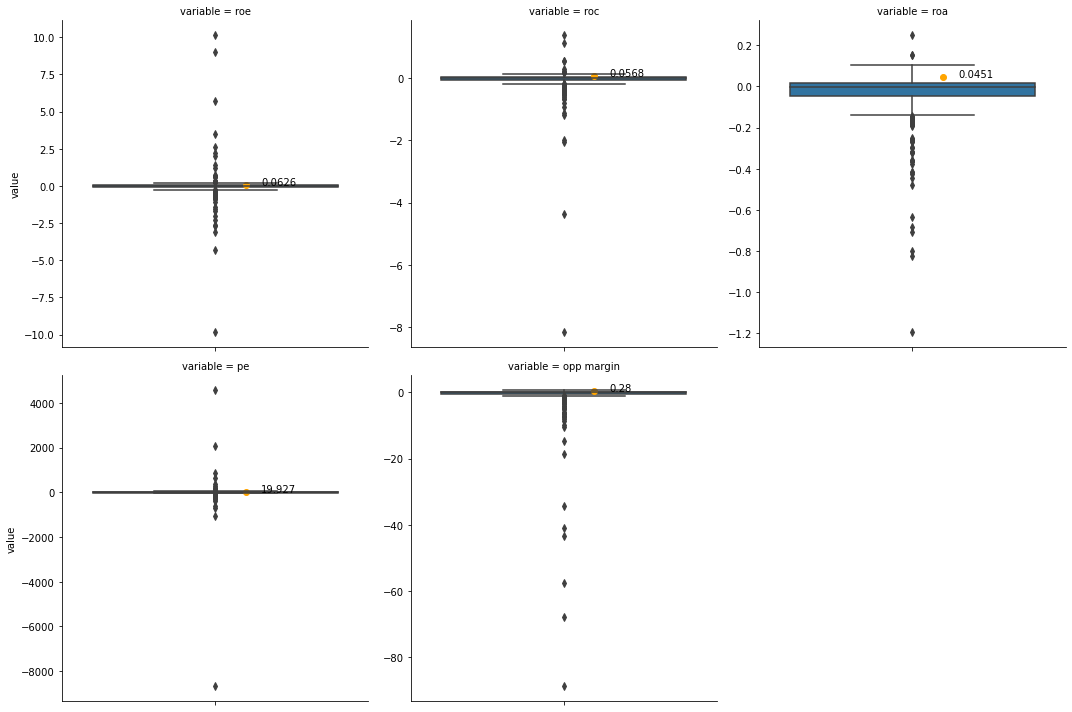

In [28]:
melt = sector_raw.melt(id_vars = 'ticker').dropna()

def annotate(data, **kws):
    n = np.round(data.value.loc[data.ticker==ticker].values[0], 4)
    ax = plt.gca()
    ax.text(.15, n, f"{n}")
    ax.scatter(.1, n, color = 'orange')
        
g = sns.FacetGrid(melt, col="variable", sharey=False,  col_wrap=3, height=5)
g.map_dataframe(sns.boxplot, y="value")
g.map_dataframe(annotate)

### Industry

In [29]:
percentiles = industry_percentile_frames.get(industry)
percentiles[ ['index'] + box_cols[1:]]

,index,roe,roc,roa,pe,opp margin
0,low,-0.26,-0.07,-0.05,-26.10,-0.39
1,Q1,-0.14,-0.04,-0.03,-20.89,-0.29
2,median,-0.03,-0.00,-0.00,-2.22,0.05
3,Q3,0.01,0.01,0.01,6.13,0.20
4,high,0.04,0.03,0.03,21.59,0.40


In [30]:
ranks = industry_rank_frames.get(industry)
ranks = ranks.loc[ranks.ticker == ticker]
ranks[ ['ticker'] + box_cols[1:]]

,ticker,roe,roc,roa,pe,opp margin
2260,GOOGL,0.78,0.93,1.00,0.89,0.96


In [31]:
industry_raw = mrq_fundamentals[box_cols].loc[mrq_fundamentals.industry == industry].dropna()

In [32]:
this_ticker =industry_raw[box_cols].loc[industry_raw.ticker == ticker] 
this_ticker

,ticker,roe,roc,roa,pe,opp margin
2436,GOOGL,0.0626,0.0568,0.0451,19.9270,0.2800


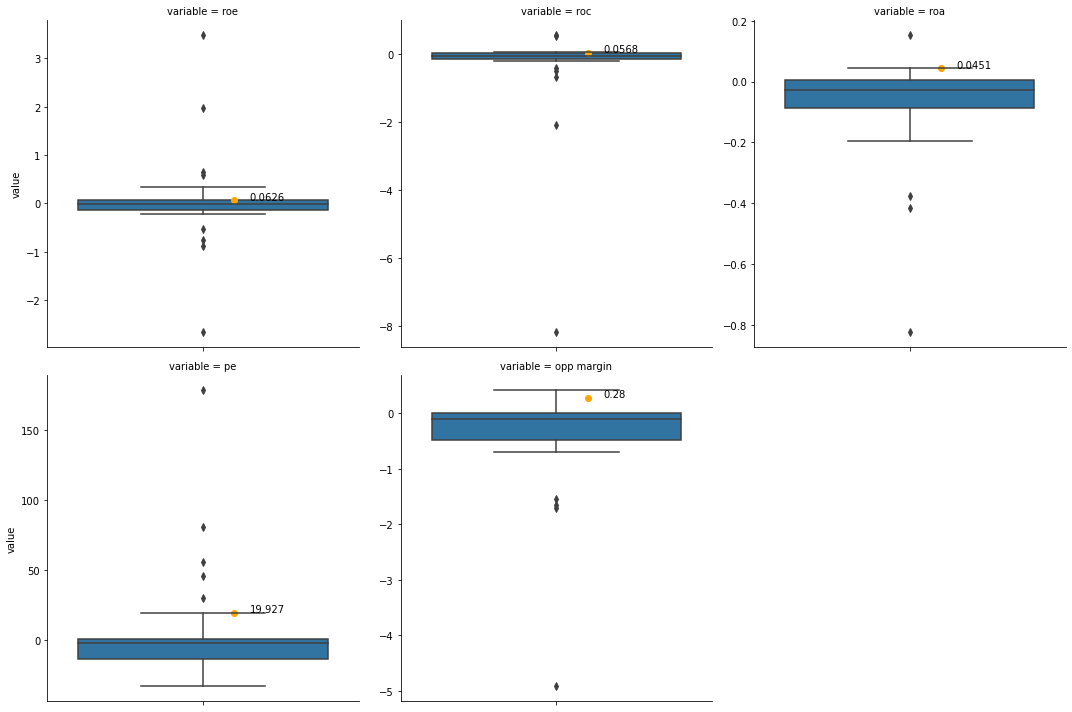

In [33]:
melt = industry_raw.melt(id_vars = 'ticker').dropna()

def annotate(data, **kws):
    n = np.round(data.value.loc[data.ticker==ticker].values[0], 4)
    ax = plt.gca()
    ax.text(.15, n, f"{n}")
    ax.scatter(.1, n, color = 'orange')
        
g = sns.FacetGrid(melt, col="variable", sharey=False,  col_wrap=3, height=5)
g.map_dataframe(sns.boxplot, y="value")
g.map_dataframe(annotate)